In [ ]:
import pandas as pd
import numpy as np

import os
import sys
from pathlib import Path
from dotenv import load_dotenv
from typing import List

import matplotlib.pyplot as plt

# RUS
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

load_dotenv()

DATA_PATH = Path(os.getenv("DATA_PATH"))

# only for .ipynb because relative imports don't work
root_path = (DATA_PATH.parent) 
os.chdir(str(root_path))
 
import src.training.plotting as p
import src.training.postprocessing as pp
import src.training.pre_training as t

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

# import models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Prepare Data

In [ ]:
df = t.get_music_df()

## Distribution of Popularity

<BarContainer object of 5 artists>

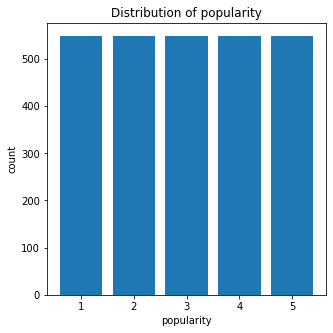

In [22]:
X = df.values[:, :15]
y = df["popularity"].apply(t.encode_popularity)

X, y = RandomUnderSampler(random_state=42).fit_resample(X,y)
# X, y = RandomOverSampler(random_state=42).fit_resample(X,y)

# Plot dist
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlabel("popularity")
ax.set_ylabel("count")
ax.set_title("Distribution of popularity")
plt.bar(list(set(y)), pp.count_distribution(y))


In [ ]:

# original_distr = [plt.bar, {"x": list(set(y)), "height": list(pd.DataFrame(y).value_counts(sort=False))}, "popularity classes", "sample count", "Original distribution of samples regarding popularity"]

# plots = []
# plots.append(original_distr)

# draw unifrom sample distribution
# X, y = RandomUnderSampler(random_state=42).fit_resample(X,y)
# X, y = RandomOverSampler(random_state=42).fit_resample(X,y)

# uniform_distr = [plt.bar, {"x": list(set(y)), "height": list(pd.DataFrame(y).value_counts(sort=False))}, "popularity classes", "sample count", "Uniform distribution of samples regarding popularity"]

# plots.append(uniform_distr)

# p.plots_from_list("Uniform distribution calc", plots, "music", "uni_calc_2")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# print(X_train.shape)
# print(X_test.shape)
# print(X_test)

## Gaussian Naive Bayes

In [ ]:
print("Gaussian Naive Bayes")
gaussian_clf = GaussianNB()

# fit the model
gaussian_clf.fit(X_train, y_train)

pp.print_metrics(gaussian_clf, X_test, y_test)

## SVM

In [ ]:
# print("SVC")
# svc_clf = SVC()

# # fit the model
# svc_clf.fit(X_train, y_train)

# pp.print_metrics(svc_clf, X_test, y_test)

## Neural Network

In [ ]:
print("Neural Network")
nn_clf = MLPClassifier()

# fit the model
nn_clf.fit(X_train, y_train)

pp.print_metrics(nn_clf, X_test, y_test)

## K-Neighbours Classifier

In [ ]:
print("K-Neighbours Classifier")
knn_clf = KNeighborsClassifier()

# fit the model
knn_clf.fit(X_train, y_train)

pp.print_metrics(knn_clf, X_test, y_test)

## Decision Trees

In [ ]:
print("Decision Trees")
dt_clf = DecisionTreeClassifier()

# fit the model
dt_clf.fit(X_train, y_train)

pp.print_metrics(dt_clf, X_test, y_test)

## Random forest

In [ ]:
# use different number of trees in forest (comparing different hyperparameters)
forest_size = [10,20,50,100]

# set seed for random state to get compareable results in every execution (forest randomness)
np.random.seed(500)

for trees in forest_size:
    # set forest size
    print("Predicting with forest size " + str(trees))
    rf = RandomForestClassifier(n_estimators=trees)

    # fit the model
    rf.fit(X_train, y_train)

    pp.print_metrics(rf, X_test, y_test)
    print("--------\n")

## Result Plotting

In [ ]:
title = "Dataset Music V1 + unpredicted popularity"
x = df["explict"]
y = df["popularity"]
p.disp_scatter(x, y, "explicit", "popularity", title)

In [ ]:
# plt.title("Dataset Music V1 + unpredicted popularity")

# plt.xlabel("popularity")
# plt.ylabel("song count")
# plt.bar(list(set(y_predict)),pp.count_distribution(y_predict))
# plt.show()
y_predict = dt_clf.predict(X_test)


In [ ]:
# Confusion matrix
fig, cax = plt.subplots(figsize=(10,10)) # subplot for larger size
cax.set_title("Random Forest (size 100) Accuracy - Undersampling", fontsize=15)
plot_confusion_matrix(estimator=rf, X=X_test, y_true=y_test, cmap=plt.cm.Blues,normalize=None,values_format=".2f",ax=cax)

plt.show()

In [ ]:
import src.training.postprocessing as pp

dummy = [x, y, "popularity", "song_count", "Plot Name"]

m = pp.get_metrics(knn_clf, X_test, y_test)

plist = [].append((plt.scatter, {"x": x,"y": y,"s": 5, "alpha": 0.5}, "xlabel", "ylabel", "p_name"))

y_lst = list(map(lambda x: len(x[1]),pd.DataFrame(y_test).groupby(0, as_index=True)))

plist.append((plt.bar, {"x": list(range(0,10)),"height": y_lst}, "popularity", "song count", "Dataset Music V1 + unpredicted popularity"))

p.plots_from_list(m, plist, "music", "test_plots_from_list_16")
